In [2]:
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt

#--- Functions ---#
#-- Cleaning up source data --#
def clean_sd(path,ec):
    cd = []
    with open(path,'r') as f:
        for line in f:
            columns = line.strip().split('\t')
            if len(columns)<ec:
                columns += [''] * (ec - len(columns))
            elif len(columns)<ec:
                columns = columns[:2] + [' '.join(columns[2:])]
            
            cd.append(columns)

    return cd

def complete_sd(path,cn):
    """
    Completes source data by adding arrival events to corresponding workstations
    """
    sd = []
    WS = ["W1","W2","W3"]
    with open(path,'r') as f:
        for line in f:
            columns = line.strip().split('\t')
            #Translate creation event into arrival at WS 1
            if columns[2] == "Created":
                columns[2] = WS[0]
                columns.append("A")
                sd.append(columns)
            
            elif columns[3] == "D":
                sd.append(columns)
                W_departing = WS.index(columns[2])

                if W_departing < 2:
                    new_entry = [None]*4
                    new_entry[:2] = columns[:2]
                    new_entry[2:] = [WS[W_departing+1],"A"]
                    sd.append(new_entry)
    
    sd_c = pd.DataFrame(sd,columns=cn)
    sd_c["time"] = pd.to_numeric(sd_c["time"])
    return sd_c

def split_sd(sd_c,ws):
    """
    Devide completed source data per workstation
    """
    sd_s = sd_c.loc[sd_c.workstation == ws].copy()
    sd_s = sd_s.drop("workstation",axis=1)
    return sd_s

def get_arrival(sd_c,hb):
    """
    Determines the mean, standard deviation and coefficient of covariance for lots and batches (if applicable)
    Returns the batch structure if applicable
    """
    # select arrival data and determine the difference between arrivals
    Lot_dT = sd_c[sd_c['event'] == 'A']['time'].diff()
    # Determine mean, standard deviation and coefficient of covariance
    Lot_mean = Lot_dT.mean()
    Lot_std = Lot_dT.std()
    Lot_CoV = Lot_std/Lot_mean
    
    # handle as batch
    if hb:
        # build batch data structure
        Batch = build_batch_view(sd_c)
        # select arrival data and determine the difference between arrivals
        Batch_dT = Batch[Batch['event'] == 'A']['time'].diff()
        Batch_mean = Batch_dT.mean()
        Batch_std = Batch_dT.std()
        Batch_CoV = Batch_std/Batch_mean
    else:
        Batch = None
        Batch_mean = None
        Batch_std = None
        Batch_CoV = None

    result = pd.DataFrame({
        "Workstation": ["Batch", "Lot"],
        "Mean": [Batch_mean, Lot_mean],
        "Std": [Batch_std, Lot_std],
        "CoV": [Batch_CoV, Lot_CoV]})

    # print(result)
    return result, Batch

def get_distribution(EPT_r):
    """
    Determines the EPT mean, standard deviation and coefficient of variance
    Additionally the amount of realizations is determined for reporting purpouses
    """
    # Group data by WIP levels and determine the count, mean and standard deviation for each WIP level
    EPT_distribution = EPT_r.groupby('sw')['EPT'].agg(['count','mean','std'])
    # Determine the covariance: standard deviation / mean
    EPT_distribution['CoV'] = EPT_distribution['std'] / EPT_distribution['mean']

    # Group data by Number of lots in the buffer and determine the count, mean and standard deviation for each WIP level
    OT_distribution = EPT_r.groupby('aw')['k'].agg(['count','mean','std'])
    # Determine the covariance: standard deviation / mean
    OT_distribution['CoV'] = OT_distribution['std'] / OT_distribution['mean']
    
    #print(EPT_distribution)
    #print(OT_distribution)
    return EPT_distribution, OT_distribution

#-- EPT calculations --#
def get_ept_data(df):
    def detOvert(xs, i):
        ys = []
        while xs:
            j, aw = xs[0]       # head(xs)
            xs = xs[1:]         # tail(xs)
            if j < i:
                ys.append((j, aw))
            elif j == i:
                return ys + xs, len(ys), aw 
        raise ValueError(f"Lot {i} not found in system")

    initial_wip = 0
    non_tracked_lots = list()  # lots not tracked by the system

    # count initial WIP 
    for lot in df.lot.unique():
        if not df.loc[df.lot == lot, "event"].str.contains("A").any():
            initial_wip += 1
            non_tracked_lots.append(lot)

    # prefil xs with initial WIP
    xs = [(lot, initial_wip) for lot in non_tracked_lots] #state of system,
    s, sw = None, None          #  EPT start time, WIP at start
    records = []                        # output rows

    for τ, i, ev, *_ in df.itertuples(index=False, name=None):

        if ev.upper() == "A":           
            if not xs:                  # empty system -> new EPT
                s, sw = τ, 1
            xs.append((i, len(xs)))     # len(xs) is WIP before this arrival

        elif ev.upper() == "D":         

            xs, k, aw = detOvert(xs, i)

            if i not in non_tracked_lots:
                # determine EPT
                ept = τ - s
                # save record
                records.append(dict(lot=i, EPT=ept, sw=sw, k=k, aw=aw))

            # start a new EPT if system still contains lots
            if xs:
                s, sw = τ, len(xs)

        else:
            raise ValueError(f"Unknown event type '{ev}'")
    results = pd.DataFrame(records)
    return results

def build_batch_view(df: pd.DataFrame):
    # Simultaneous departures are a batch
    dep = df[df.event.str.upper() == "D"].copy()
    dep["group"] = dep.groupby("time").ngroup()

    batches = dep.groupby("group").filter(lambda g: len(g) > 0).copy()

    # create a batch id for each group
    group2virtual = {g: f"B{n}" for n, g in enumerate(sorted(batches.group.unique()))}
    batches["virtual"] = batches.group.map(group2virtual)

    lot2batch  = dict(zip(batches.lot, batches.virtual))

    # arrival = latest arrival of any member in the batch
    arrivals = (
        df[df.event.str.upper() == "A"]
          .loc[df.lot.isin(lot2batch)]                 # only batched lots
          .assign(virtual=lambda d: d.lot.map(lot2batch))
          .groupby("virtual", as_index=False)
          .agg(time=("time", "max"),
               lot_ids=("lot", lambda x: list(x)))     # collect ids
          .assign(event="A", lot=lambda d: d.virtual)  # rename columns
          .drop(columns="virtual")
    )

    # departure = common departure time 
    departures = (
        batches.groupby("virtual", as_index=False)
               .agg(time=("time", "first"),
                    lot_ids=("lot", lambda x: list(x)))
               .assign(event="D", lot=lambda d: d.virtual)
               .drop(columns="virtual")
    )

    drop_lots = set(lot2batch)                       # originals replaced by batch rows

    df_batch = (
        pd.concat([df, arrivals, departures], ignore_index=True)
          .loc[lambda d: ~d["lot"].isin(drop_lots)]  
          .sort_values("time")
          .reset_index(drop=True)
    )

    return df_batch


#--- Take Home solver ---#
#-- variables --#
# source data
sd_path = 'data/group07.txt'
expected_nr_columns = 4
column_names = ['time', 'lot', "workstation", 'event']

#-- Load assignment data --#
sd_completed = complete_sd(sd_path,column_names)
sd_W1 = split_sd(sd_completed,"W1")
sd_W2 = split_sd(sd_completed,"W2")
sd_W3 = split_sd(sd_completed,"W3")

Arival_W1, _ = get_arrival(sd_W1,False)
Arival_W2, _ = get_arrival(sd_W2,False)
Arival_W3, _ = get_arrival(sd_W3,False)
Arival_W2, Batch_W2 = get_arrival(sd_W2,True)

EPT_W1r = get_ept_data(sd_W1)
EPT_W2r = get_ept_data(Batch_W2)
EPT_W3r = get_ept_data(sd_W3)

[EPTd_W1, OTd_W1] = get_distribution(EPT_W1r)
[EPTd_W2, OTd_W2] = get_distribution(EPT_W2r)
[EPTd_W3, OTd_W3] = get_distribution(EPT_W3r)



In [38]:
import math

def compute_ept_data(EPT_W1r, EPT_W2r, EPT_W3r, Batch_W2):
    return {
        'EPT_W1_wip3plus': EPT_W1r[EPT_W1r['aw'] >= 3]['EPT'].mean(),
        'EPT_W2_all': EPT_W2r['EPT'].mean(),
        'EPT_W3_all': EPT_W3r['EPT'].mean(),
        'c_e2_W1': EPT_W1r[EPT_W1r['aw'] >= 3]['EPT'].var() / (EPT_W1r[EPT_W1r['aw'] >= 3]['EPT'].mean() ** 2),
        'c_e2_W2': EPT_W2r['EPT'].var() / (EPT_W2r['EPT'].mean() ** 2),
        'c_e2_W3': EPT_W3r['EPT'].var() / (EPT_W3r['EPT'].mean() ** 2),
        'W2_batch_size': len(Batch_W2['lot_ids'].explode()) / len(Batch_W2)
    }

def compute_arrival_rate(Arival_W1, Arival_W2, Arival_W3):
    return {
        'W1_arrival_rate': 1 / Arival_W1['Mean'][1],
        'w1_arrival_rate_SCV': Arival_W1['CoV'][1]**2,
        'W2_arrival_rate': 1 / Arival_W2['Mean'][1],
        'W3_arrival_rate': 1 / Arival_W3['Mean'][1]
    }

# Execute and print everything
ept_data = compute_ept_data(EPT_W1r, EPT_W2r, EPT_W3r, Batch_W2)
arrival_rate = compute_arrival_rate(Arival_W1, Arival_W2, Arival_W3)

# put it all together in a dataframe
ept_data = pd.DataFrame([ept_data])
arrival_rate = pd.DataFrame([arrival_rate])
# Merge the dataframes into a single table
all_data = pd.concat([ept_data, arrival_rate], axis=1)

# Display the merged table
display(all_data) # This is all in minutes

,EPT_W1_wip3plus,EPT_W2_all,EPT_W3_all,c_e2_W1,c_e2_W2,c_e2_W3,W2_batch_size,W1_arrival_rate,w1_arrival_rate_SCV,W2_arrival_rate,W3_arrival_rate
0,4.7556e+01,5.5464e+02,3.6859e+01,9.9785e-01,1.0589e-02,9.8945e-01,9.9137e+00,1.3511e-02,1.0154e+00,1.3513e-02,1.3528e-02



Tangent parameters per machine (per shift):
Machine  Utilization      Slope   Intercept
     M1   0.0000e+00 3.7597e+04  3.7849e-04
     M2   0.0000e+00 2.6717e+01 -1.2023e+02
     M3   0.0000e+00 8.9548e+04  4.8836e-04
     M1   3.5000e-01 5.5020e+00  1.6056e+00
     M2   3.5000e-01 8.4834e-02 -2.4407e-01
     M3   3.5000e-01 1.3418e+01  2.0717e+00
     M1   7.0000e-01 7.4379e-01  4.0758e+00
     M2   7.0000e-01 1.1516e-02  2.9768e-01
     M3   7.0000e-01 1.9518e+00  5.2590e+00
     M1   8.0000e-01 3.1335e-01  5.0463e+00
     M2   8.0000e-01 4.8597e-03  4.1084e-01
     M3   8.0000e-01 8.4816e-01  6.5111e+00
     M1   9.0000e-01 7.5965e-02  6.1931e+00
     M2   9.0000e-01 1.1804e-03  5.2575e-01
     M3   9.0000e-01 2.1314e-01  7.9909e+00
     M1   1.0000e+00 7.5205e-08  7.5679e+00
     M2   1.0000e+00 4.7361e-09  6.4874e-01
     M3   1.0000e+00 2.1990e-07  9.7647e+00


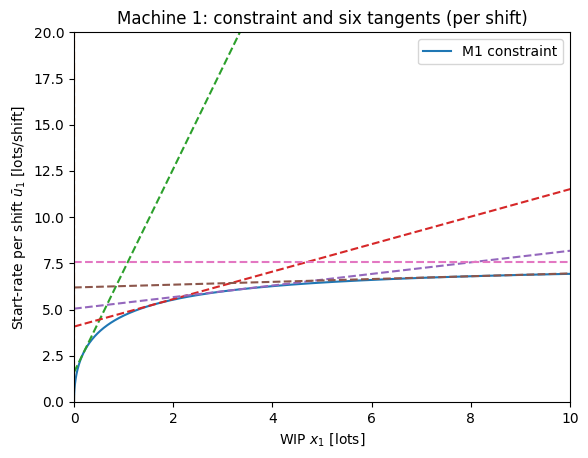

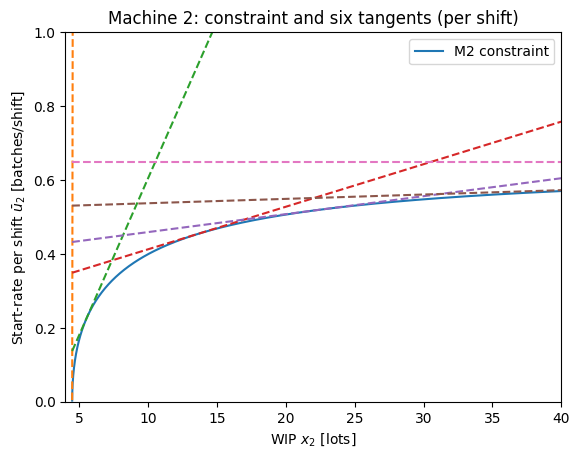

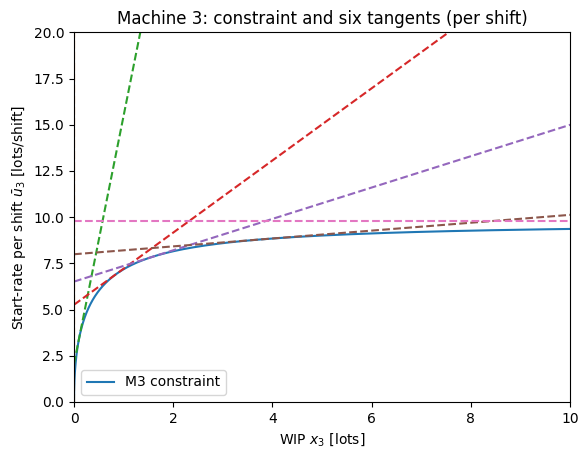

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# ------------------------------------------------------------------
#  Constants (all times in minutes)
# ------------------------------------------------------------------
TE1 = 47.56          # mean service time, M1, lot
TE2 = 554.64         # mean service time, M2, batch
TE3 = 36.86          # mean service time, M3, lot
K   = 10             # fixed batch size of M2

CA1 = 1.015         # SCV of arrivals at M1          (c_{a,1}²)
CE1 = 0.998          # SCV of service  at M1          (c_{e,1}²)
CE2 = 0.0106         # SCV of (batch) service at M2   (c_{e,2}²)
CE3 = 0.989          # SCV of service  at M3          (c_{e,3}²)

H = 360.0            # minutes per shift  ← SCALE FACTOR

# Kingman pre-factor for the M1  quadratics
A1 = 0.5 * (CA1 + CE1) * TE1**2                      # a₁

# ------------------------------------------------------------------
#  Helper functions for M1 (single-server)
# ------------------------------------------------------------------
def x1_from_u(u1: float) -> float:
    """WIP in buffer 1 as a function of lot start-rate u₁ (per min)."""
    return A1 * u1**2 / (1.0 - u1 * TE1)

def du1_dx1(u1: float) -> float:
    """Slope ∂u₁/∂x₁ at the operating point u₁."""
    return (1.0 - u1 * TE1) ** 2 / (2.0 * A1 * u1 - A1 * TE1 * u1**2)


# ------------------------------------------------------------------
#  Helper functions for M2 (batch machine, convex limit)
# ------------------------------------------------------------------
def c_d1_sq(rho1: float) -> float:
    """Departure SCV of M1 (c_{d,1}²)."""
    return (1.0 - rho1**2) * CA1 + rho1**2 * CE1

def x2_from_u(u2: float, u1: float) -> float:
    """
    WIP in buffer 2 as function of the batch start-rate u₂ (per min) and upstream u₁.
    Balanced line ⇒ lot arrival rate to M2 = k·u₂.
    """
    rho2   = u2 * TE2
    cd1_sq = c_d1_sq(u1 * TE1)
    ca_b_sq = cd1_sq / K
    c_sum  = ca_b_sq + CE2
    return (K - 1) / 2.0 + K**2 * u2 * c_sum / 2.0 * rho2 / (1.0 - rho2) * TE2

def g2_u(x2: float, u1: float) -> float:
    """Explicit inverse u₂(x₂;u₁)."""
    cd1_sq = c_d1_sq(u1 * TE1)
    A = K * TE2**2 / 2.0 * (K * CE2 + cd1_sq)
    D = x2 - (K - 1) / 2.0
    disc = max(D**2 * TE2**2 + 4.0 * A * D, 0.0)
    return (-D * TE2 + sqrt(disc)) / (2.0 * A)

def du2_dx2(u2: float, u1: float, dx: float = 1e-4) -> float:
    """
    Numerical slope ∂u₂/∂x₂ via forward difference of the explicit inverse
    (accurate enough for the supporting-line envelope).
    """
    x0 = x2_from_u(u2, u1)
    return (g2_u(x0 + dx, u1) - u2) / dx


# ------------------------------------------------------------------
#  Helper functions for M3  (single-server, arrival SCV depends on M2)
# ------------------------------------------------------------------
def c_a3_sq(u2: float, u1: float) -> float:
    """Arrival SCV at M3 = departure SCV of M2 (c_{d,2}²)."""
    rho1 = u1 * TE1
    rho2 = u2 * TE2
    cd1_sq = c_d1_sq(rho1)
    ca_b_sq = cd1_sq / K
    return (1.0 - rho2**2) * ca_b_sq + rho2**2 * CE2   # c_{d,2}²

def x3_from_u(u3: float, ca3_sq: float) -> float:
    """WIP in buffer 3 for given lot start-rate u₃ (per min)."""
    a3 = 0.5 * (ca3_sq + CE3) * TE3**2
    return a3 * u3**2 / (1.0 - u3 * TE3)

def du3_dx3(u3: float, ca3_sq: float) -> float:
    """Analytic slope ∂u₃/∂x₃."""
    a3 = 0.5 * (ca3_sq + CE3) * TE3**2
    return (1.0 - u3 * TE3) ** 2 / (2.0 * a3 * u3 - a3 * TE3 * u3**2)


# ------------------------------------------------------------------
#  Tangent construction
# ------------------------------------------------------------------
UTIL = np.array([0.0, 0.35, 0.70, 0.80, 0.90, 1.0])
EPS_LO  = 1.0e-4   # avoid rho = 0   → infinite slope
EPS_HI  = 0.9999   # avoid rho = 1   → infinite WIP

tangents_shift = {'M1':[], 'M2':[], 'M3':[]}
records = [] 

for rho in UTIL:
    # ----------  M1  ------------------------------------------------
    rho1 = np.clip(rho, EPS_LO, EPS_HI)
    u1   = rho1 / TE1
    x1   = x1_from_u(u1)
    m1   = du1_dx1(u1)
    b1   = u1 - m1 * x1
    m1_s, b1_s = H*m1, H*b1        # per-shift versions
    tangents_shift['M1'].append((m1_s, b1_s))
    records.append({'Machine':'M1', 'Utilization':rho,
                    'Slope':m1_s, 'Intercept':b1_s})
    
    # ----------  M2  ------------------------------------------------
    rho2 = np.clip(rho, EPS_LO, EPS_HI)
    u2   = rho2 / TE2
    u1_bal = K * u2
    x2   = x2_from_u(u2, u1_bal)
    m2   = du2_dx2(u2, u1_bal)
    b2   = u2 - m2 * x2
    m2_s, b2_s = H*m2, H*b2
    tangents_shift['M2'].append((m2_s, b2_s))
    records.append({'Machine':'M2', 'Utilization':rho,
                    'Slope':m2_s, 'Intercept':b2_s})
    
    # ----------  M3  ------------------------------------------------
    rho3 = np.clip(rho, EPS_LO, EPS_HI)
    u3   = rho3 / TE3
    u2_bal = u3 / K
    ca3   = c_a3_sq(u2_bal, u3)
    x3    = x3_from_u(u3, ca3)
    m3    = du3_dx3(u3, ca3)
    b3    = u3 - m3 * x3
    m3_s, b3_s = H*m3, H*b3
    tangents_shift['M3'].append((m3_s, b3_s))
    records.append({'Machine':'M3', 'Utilization':rho,
                    'Slope':m3_s, 'Intercept':b3_s})

# print the tangent table
tangent_df = pd.DataFrame(records)
print("\nTangent parameters per machine (per shift):")
print(tangent_df.to_string(index=False))

# ------------------------------------------------------------------
#  Curves for plotting (per shift)
# ------------------------------------------------------------------
num_points = 400
# Machine 1
u1_grid = np.linspace(0.0 + 1e-5, 0.999/TE1, num_points)
x1_curve = x1_from_u(u1_grid)
u1_grid_shift = H * u1_grid
# Machine 2
u2_grid = np.linspace(0.0 + 1e-5, 0.999/TE2, num_points)
u1_bal_grid = K * u2_grid
x2_curve = np.array([x2_from_u(u2, u1_bal) for u2, u1_bal in zip(u2_grid, u1_bal_grid)])
u2_grid_shift = H * u2_grid
# Machine 3
u3_grid = np.linspace(0.0 + 1e-5, 0.999/TE3, num_points)
u2_bal_grid = u3_grid / K
ca3_grid = np.array([c_a3_sq(u2b, u3) for u2b, u3 in zip(u2_bal_grid, u3_grid)])
x3_curve = np.array([x3_from_u(u3, ca3) for u3, ca3 in zip(u3_grid, ca3_grid)])
u3_grid_shift = H * u3_grid

# ------------------------------------------------------------------
#  Plot Machine 1
# ------------------------------------------------------------------
plt.figure()
plt.plot(x1_curve, u1_grid_shift, label='M1 constraint')
for m, b in tangents_shift['M1']:
    plt.plot(x1_curve, m * x1_curve + b, linestyle='--')
plt.xlabel('WIP $x_1$ [lots]')
plt.ylabel('Start-rate per shift $\\bar{u}_1$ [lots/shift]')
plt.title('Machine 1: constraint and six tangents (per shift)')
plt.ylim(bottom=0,top=20)
plt.xlim(0,10)
plt.legend()

# ------------------------------------------------------------------
#  Plot Machine 2
# ------------------------------------------------------------------
plt.figure()
plt.plot(x2_curve, u2_grid_shift, label='M2 constraint')
for m, b in tangents_shift['M2']:
    plt.plot(x2_curve, m * x2_curve + b, linestyle='--')
plt.xlabel('WIP $x_2$ [lots]')
plt.ylabel('Start-rate per shift $\\bar{u}_2$ [batches/shift]')
plt.title('Machine 2: constraint and six tangents (per shift)')
plt.ylim(bottom=0,top=1)
plt.xlim(4,40)
plt.legend()

# ------------------------------------------------------------------
#  Plot Machine 3
# ------------------------------------------------------------------
plt.figure()
plt.plot(x3_curve, u3_grid_shift, label='M3 constraint')
for m, b in tangents_shift['M3']:
    plt.plot(x3_curve, m * x3_curve + b, linestyle='--')
plt.xlabel('WIP $x_3$ [lots]')
plt.ylabel('Start-rate per shift $\\bar{u}_3$ [lots/shift]')
plt.title('Machine 3: constraint and six tangents (per shift)')
plt.ylim(bottom=0,top=20)
plt.xlim(0,10)
plt.legend()

plt.show()
